#####   
# KNN & Ensemble Methods
 - Not Suitable for Noisy Data
 - KNN is a Lazy Learner
 
#####   

# Objective:
 - To detect diabetes using **K Nearest Kneibours** and **Ensemble Methods**

# Loading Libraries

In [1]:
# importing required modules

import numpy  as np
import pandas as pd
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',None)

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)

#####   
# Loading and Exploring the Data

In [2]:
# (input) importing Raw data

data_set_name    = 'Pima_Diabetes'
estimated_column = 'Class'

data_file  = 'Pima_Diabetes.csv'
data_sheet = 'Pima_Diabetes'

# (auto)
df_raw = pd.read_csv( data_file, header=0 ) # , delimiter=','
print(f'there are {df_raw.shape[0]} rows and {df_raw.shape[1]} columns.')

df_raw.tail() 

there are 768 rows and 9 columns.


,Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


#####   

In [3]:
# (auto) Observing Random Records
np.random.seed(3)
cm = sns.light_palette('#ffcccb', as_cmap=True)

df_raw.sample(n=200).style.\
    background_gradient(subset=['Class'], cmap=cm).\
    bar(subset=['Pregnancy','Test','Pedi'], color='deeppink').\
    bar(subset=['Blood_Plasma','Skin','Body_Mass_Index','Age'], color='cyan').\
    bar(subset=['Blood_Pressure'], color='deeppink').\
    highlight_null(color='lime').\
    format(precision=2).\
    hide(axis="index")       #.to_excel('styled.xlsx', engine='openpyxl')

Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
1,101,50,15,36,24.20,0.53,26,0
4,156,75,0,0,48.30,0.24,32,1
1,97,66,15,140,23.20,0.49,22,0
2,197,70,99,0,34.70,0.57,62,1
13,106,72,54,0,36.60,0.18,45,0
4,154,62,31,284,32.80,0.24,23,0
5,99,74,27,0,29.00,0.20,32,0
2,68,62,13,15,20.10,0.26,23,0
4,110,92,0,0,37.60,0.19,30,0
6,114,0,0,0,0.00,0.19,26,0


#
# Info & Describe

In [4]:
print( df_raw.info() )
print('')
df_raw.describe().T.style.format(precision=1)   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Pregnancy        768 non-null    int64  
 1   Blood_Plasma     768 non-null    int64  
 2   Blood_Pressure   768 non-null    int64  
 3   Skin             768 non-null    int64  
 4   Test             768 non-null    int64  
 5   Body_Mass_Index  768 non-null    float64
 6   Pedi             768 non-null    float64
 7   Age              768 non-null    int64  
 8   Class            768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None



,count,mean,std,min,25%,50%,75%,max
Pregnancy,768.0,3.8,3.4,0.0,1.0,3.0,6.0,17.0
Blood_Plasma,768.0,120.9,32.0,0.0,99.0,117.0,140.2,199.0
Blood_Pressure,768.0,69.1,19.4,0.0,62.0,72.0,80.0,122.0
Skin,768.0,20.5,16.0,0.0,0.0,23.0,32.0,99.0
Test,768.0,79.8,115.2,0.0,0.0,30.5,127.2,846.0
Body_Mass_Index,768.0,32.0,7.9,0.0,27.3,32.0,36.6,67.1
Pedi,768.0,0.5,0.3,0.1,0.2,0.4,0.6,2.4
Age,768.0,33.2,11.8,21.0,24.0,29.0,41.0,81.0
Class,768.0,0.3,0.5,0.0,0.0,0.0,1.0,1.0


## Report:
 - No Empty Cells 
 - features: 'Blood_Plasma', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index' 
   - include 0 which is impossible, and means missing value
   - these 0s must be converted to np.nan

## Converting 0s to np.nan

In [5]:
Features_with_Missin_Values = ['Blood_Plasma', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index']

df_missing = df_raw.copy()
for ft in Features_with_Missin_Values:
    df_missing[ft] = df_missing[ft].replace(0,np.nan)
    
df_missing.head(10).style.\
    highlight_null(color='lime').\
    format(precision=2).\
    hide(axis="index")       #.to_excel('styled.xlsx', engine='openpyxl')

Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
6,148.00,72.00,35.00,nan,33.60,0.63,50,1
1,85.00,66.00,29.00,nan,26.60,0.35,31,0
8,183.00,64.00,nan,nan,23.30,0.67,32,1
1,89.00,66.00,23.00,94.00,28.10,0.17,21,0
0,137.00,40.00,35.00,168.00,43.10,2.29,33,1
5,116.00,74.00,nan,nan,25.60,0.20,30,0
3,78.00,50.00,32.00,88.00,31.00,0.25,26,1
10,115.00,nan,nan,nan,35.30,0.13,29,0
2,197.00,70.00,45.00,543.00,30.50,0.16,53,1
8,125.00,96.00,nan,nan,nan,0.23,54,1


#####  
# Handling Missing Values by KNNImputer 

In [6]:
from sklearn.impute import KNNImputer
imputer   = KNNImputer( n_neighbors=2, weights="distance" )   # 'distance', 'uniform'

# Features_with_Missin_Values = ['Blood_Plasma', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index'] 
X_Null    = df_missing[ Features_with_Missin_Values ].values.copy()
X_Treated = imputer.fit_transform( X_Null )

In [7]:
df_Treated    = pd.DataFrame(X_Treated, columns=Features_with_Missin_Values)
#df.columns   = [ Features_with_Missin_Values ]
df_no_missing = df_missing.copy()
df_no_missing[ Features_with_Missin_Values ] = df_Treated.copy()
print(f'there are {df_no_missing.shape[0]} rows and {df_no_missing.shape[1]} columns.') 

df_no_missing.sample(n=200).style.\
    background_gradient(subset=['Class'], cmap=cm).\
    bar(subset=['Pregnancy','Test','Pedi'], color='deeppink').\
    bar(subset=['Blood_Plasma','Skin','Body_Mass_Index','Age'], color='cyan').\
    bar(subset=['Blood_Pressure'], color='deeppink').\
    highlight_null(color='lime').\
    format(precision=2).\
    hide(axis="index")       #.to_excel('styled.xlsx', engine='openpyxl')

there are 768 rows and 9 columns.


Pregnancy,Blood_Plasma,Blood_Pressure,Skin,Test,Body_Mass_Index,Pedi,Age,Class
5,168.00,64.00,36.32,205.82,32.90,0.14,41,1
4,114.00,64.00,18.32,143.04,28.90,0.13,24,0
6,115.00,60.00,39.00,108.12,33.70,0.24,40,1
2,112.00,68.00,22.00,94.00,34.10,0.32,26,0
2,90.00,70.00,17.00,64.99,27.30,0.09,22,0
4,122.00,68.00,28.60,271.80,35.00,0.39,29,0
8,99.00,84.00,25.00,108.73,35.40,0.39,50,0
6,114.00,73.00,35.00,242.50,38.50,0.19,26,0
2,175.00,88.00,30.44,226.70,22.90,0.33,22,0
3,193.00,70.00,31.00,301.25,34.90,0.24,25,1


## Report: 
 - features: 'Blood_Plasma', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index' 
   - The 0s are replaced with appropriate values.

# Detecting Outliers by Boxplots

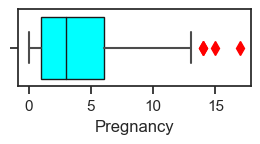

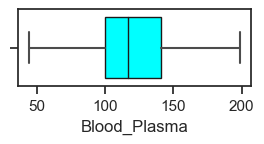

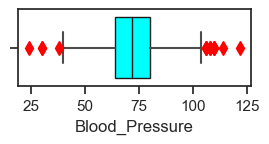

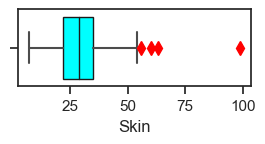

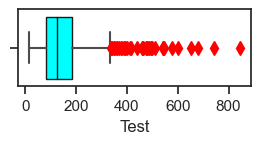

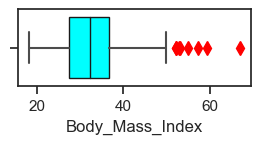

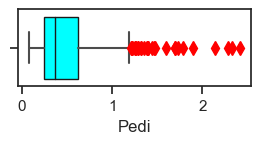

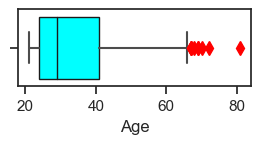

In [8]:
from   seaborn import boxplot as BoxPlot

# (auto) 
df = df_no_missing.copy()

scalar_columns = []
for col in df.columns:
    if df[col].dtype!='object' and col!=estimated_column: scalar_columns.append( col )

boxprops    = dict( linewidth=1, edgecolor='k', facecolor='cyan' )
medianprops = dict( linewidth=1, color='k' )
flierprops  = dict( marker='d', markersize=7, markerfacecolor='red', markeredgecolor='red' )

for ft in scalar_columns:
    plt.figure(  figsize=(3,1)   )
    BoxPlot( x=df[ ft ] 
           , boxprops    = boxprops
           , medianprops = medianprops
           , flierprops  = flierprops  
           )
    plt.show()

## Report: 
 - features: 'Pregnancy', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index', 'Pedi', 'Age'
   - have outliers and need treatment

# Treating Outliers

## Treating Outliers by Winsorizing

In [9]:
# Winsorizing Extreme Outliers
df_dirty = df_no_missing.copy()    
columns_with_outliers = [ 'Pregnancy', 'Blood_Pressure', 'Skin', 'Test', 'Body_Mass_Index', 'Pedi', 'Age' ]

def winsorize_by_zscore(df,ft):
    x  = df[ft].copy()
    M  = x.mean()
    SD = x.std()
    z  = (x-M) / SD
    
    upper_bound = +3
    lower_bound = -3
    
    ls = df.index[ (z > upper_bound) 
                 | (z < lower_bound) ]
    
    x_Des=sorted(x,reverse=True)
    i=0
    while x_Des[i] >=  M + 3*SD:
        i=i+1 
    MAX=x_Des[i] 
    
    x_Asc=sorted(x,reverse=False)
    i=0 
    while x_Asc[i] <=  M - 3*SD:
        i=i+1  
    MIN=x_Asc[i] 
    
    for i in range(0,len(x)):
        if   z[i] > upper_bound: x[i]=MAX
        elif z[i] < lower_bound: x[i]=MIN
            
    return [x, ls]
 

# df_no_extreme
df_no_extreme = df_dirty.copy()

index_list = []
for c in columns_with_outliers:
    c_clean, ls = winsorize_by_zscore( df_dirty, c )
    index_list.extend( ls )
    df_no_extreme.loc[ :, c ] = c_clean

## Treating Noise (Outliers) by Isolation Forest

In [10]:
from sklearn.ensemble import IsolationForest

df_dirty = df_no_extreme.copy()    

X   = df_dirty[ scalar_columns ].values.copy()
AOD = IsolationForest( contamination=0.05 ).fit( X )
flag_clean = AOD.predict( X ) == +1
df_clean   = df_dirty.loc[ flag_clean, : ]
df_clean.index = range(df_clean.shape[0])

## Observing Outliers Before Vs After Treatment

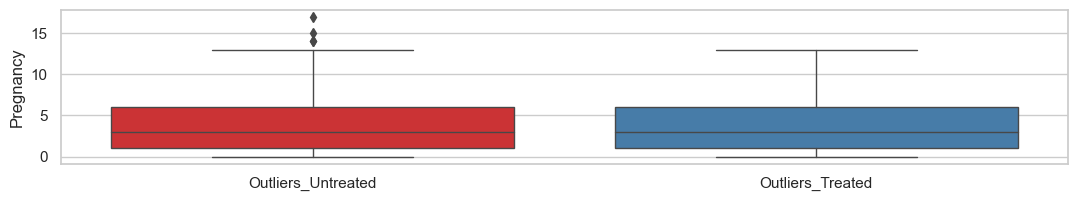

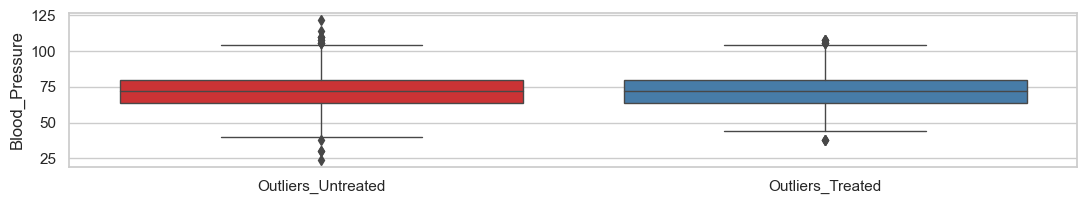

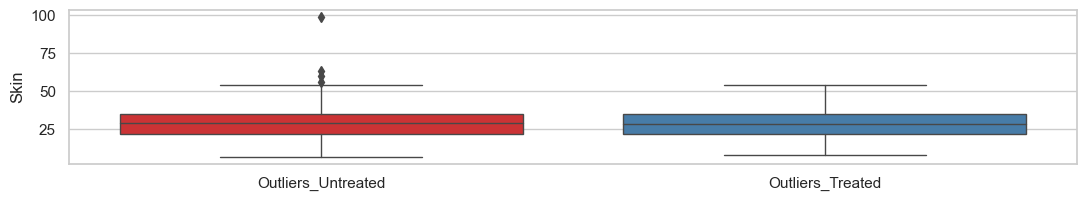

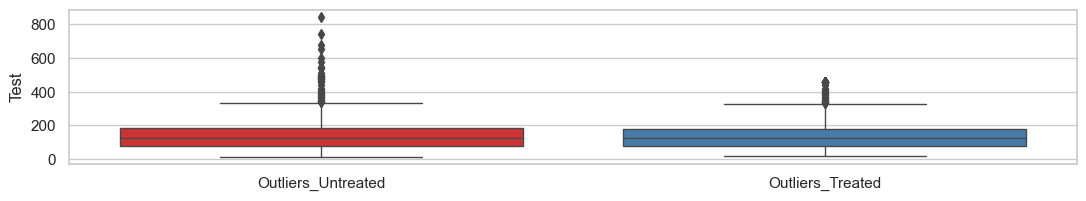

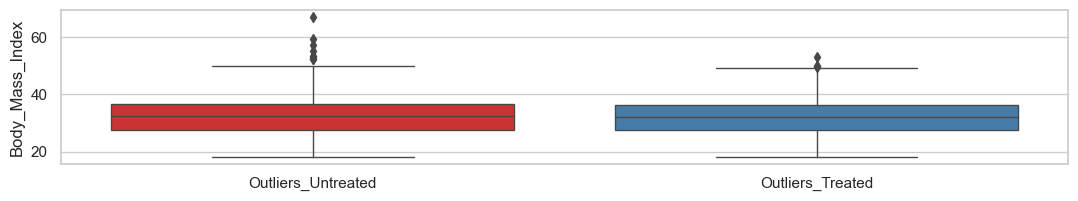

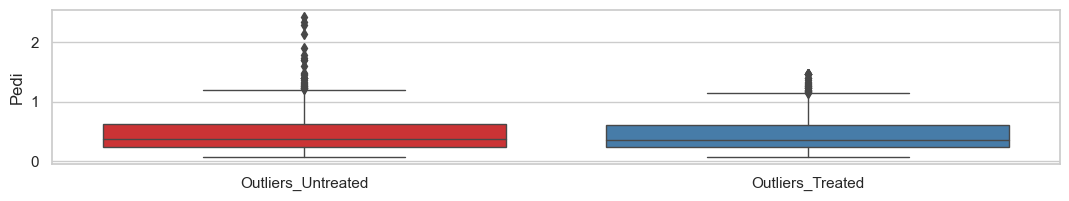

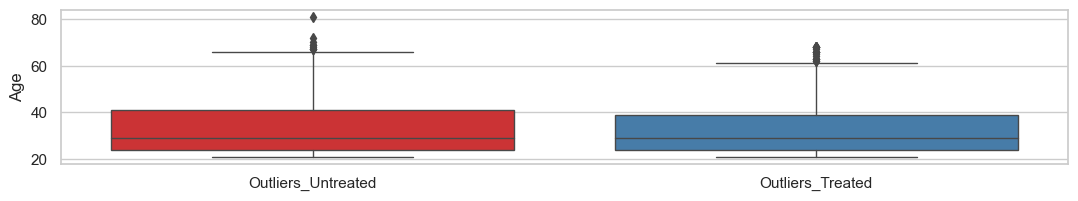

In [11]:
df_before = df_no_missing.copy()
df_before['condition']=['Outliers_Untreated']*df_before.shape[0]
df_after  = df_clean.copy()
df_after['condition'] =['Outliers_Treated']*df_after.shape[0]
df_before_after = pd.concat([df_before,df_after],axis=0)
df_before_after.head()

x   = 'condition'
for y in columns_with_outliers:
    df = df_before_after[ [x,y] ].copy().dropna().sort_values([x],ascending=[False]) 
    # BoxPlot
    sns.set(rc={'figure.figsize':(13,2)}); sns.set(style='whitegrid')
    sns_plot = sns.boxplot( x=x, y=y, data=df, linewidth=1.0, palette='Set1'); sns_plot.set_xlabel('')
    fig = sns_plot.get_figure(); plt.show()

## Report: 
 - As expected, notable reduction in range and amount of outliers is achieved.

# Checking Imbalance in Data

col_0  count
Class       
0        482
1        247


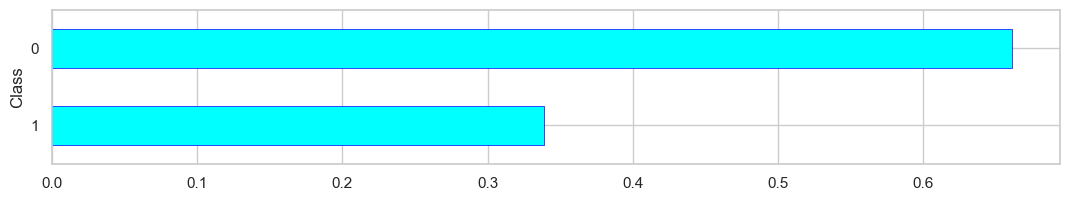

In [12]:
df = df_clean.copy()
x  = 'Class'

# Frequency Table  
freq_tab = pd.crosstab( index=df[x].astype('str'), columns='count' )
print(freq_tab.sort_values('count',ascending=False))

# Barh
L = df[x].astype('str')
L.value_counts(normalize=True).sort_values().plot.barh(linewidth=.5, edgecolor='blue', facecolor='cyan'); plt.show()

## Report: 
 - Data is **Imbalanced** and needs treatment.

# Train Test DataSets

In [13]:
from sklearn.preprocessing   import scale, LabelEncoder 
from sklearn.model_selection import train_test_split
df = df_clean.copy().sort_values(['Class'],ascending=True)

# (auto)
X = df.drop( estimated_column, axis=1 ).copy() 
y = df[ estimated_column ].copy() 
 
X_Train, X_Test, y_Train, y_Test  =  train_test_split(        
          X, LabelEncoder().fit(y).transform(y)
        , random_state  =  3
        , test_size     =  0.20
        , shuffle       =  True 
        , stratify      =  y
        )
X_Train.index = range( X_Train.shape[0] )
X_Test.index  = range( X_Test.shape[0]  ) 

# Treating Imbalance by TomekLinks AND SMOTEENN

In [14]:
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTEENN

nClasses = len( df_clean[estimated_column].astype('str').unique() )


Sampler = TomekLinks()
for i in range(nClasses):  
    X_Train_Balanced, y_Train_Balanced = Sampler.fit_resample( X_Train, y_Train )
    X_Test_Balanced,  y_Test_Balanced  = Sampler.fit_resample( X_Test,  y_Test  )
X_Train_Balanced.index = range(X_Train_Balanced.shape[0])
X_Test_Balanced.index  = range(X_Test_Balanced.shape[0])


Sampler = SMOTEENN()
for i in range(nClasses):  
    X_Train_Balanced, y_Train_Balanced = Sampler.fit_resample( X_Train_Balanced, y_Train_Balanced )
    X_Test_Balanced,  y_Test_Balanced  = Sampler.fit_resample( X_Test_Balanced,  y_Test_Balanced  )
X_Train_Balanced.index = range(X_Train_Balanced.shape[0])
X_Test_Balanced.index  = range(X_Test_Balanced.shape[0])


# Checking Balanced Data

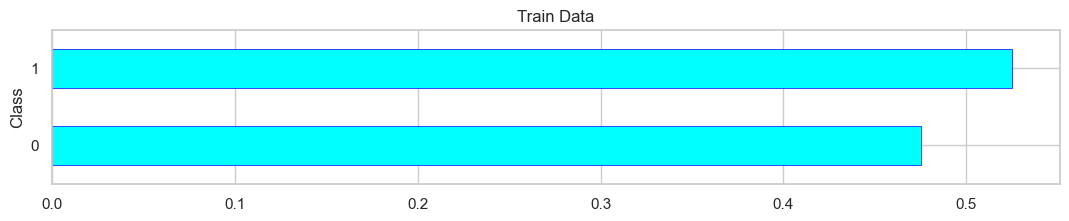

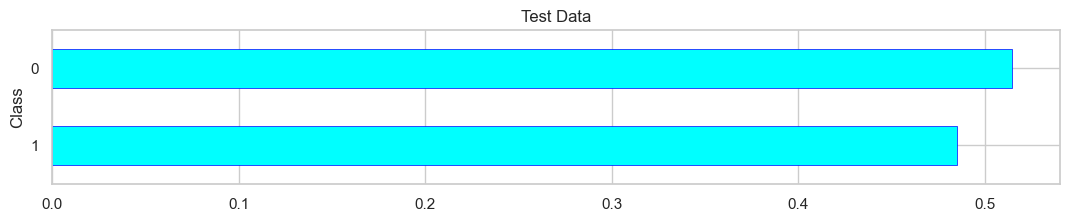

In [15]:
df_Train_Balanced            = X_Train_Balanced.copy()
df_Train_Balanced[ 'Class' ] = y_Train_Balanced.copy()

df_Test_Balanced             = X_Test_Balanced.copy()
df_Test_Balanced[ 'Class' ]  = y_Test_Balanced.copy()

x  = 'Class' 

# Train Data
df = df_Train_Balanced.copy() 
L = df[x].astype('str')
L.value_counts(normalize=True).sort_values().plot.barh(linewidth=.5, edgecolor='blue', facecolor='cyan',title='Train Data'); plt.show()

# Test Data
df = df_Test_Balanced.copy()
L = df[x].astype('str')
L.value_counts(normalize=True).sort_values().plot.barh(linewidth=.5, edgecolor='blue', facecolor='cyan',title='Test Data'); plt.show()


## Report: 
 - After Treatment, Data is **Balanced**

#####   
## Assigning Balanced Data Sets

In [16]:
X_Train = X_Train_Balanced.copy();   y_Train = y_Train_Balanced.copy()
X_Test  = X_Test_Balanced.copy();    y_Test  = y_Test_Balanced.copy()

#####   
## Observing Balanced Training Variables

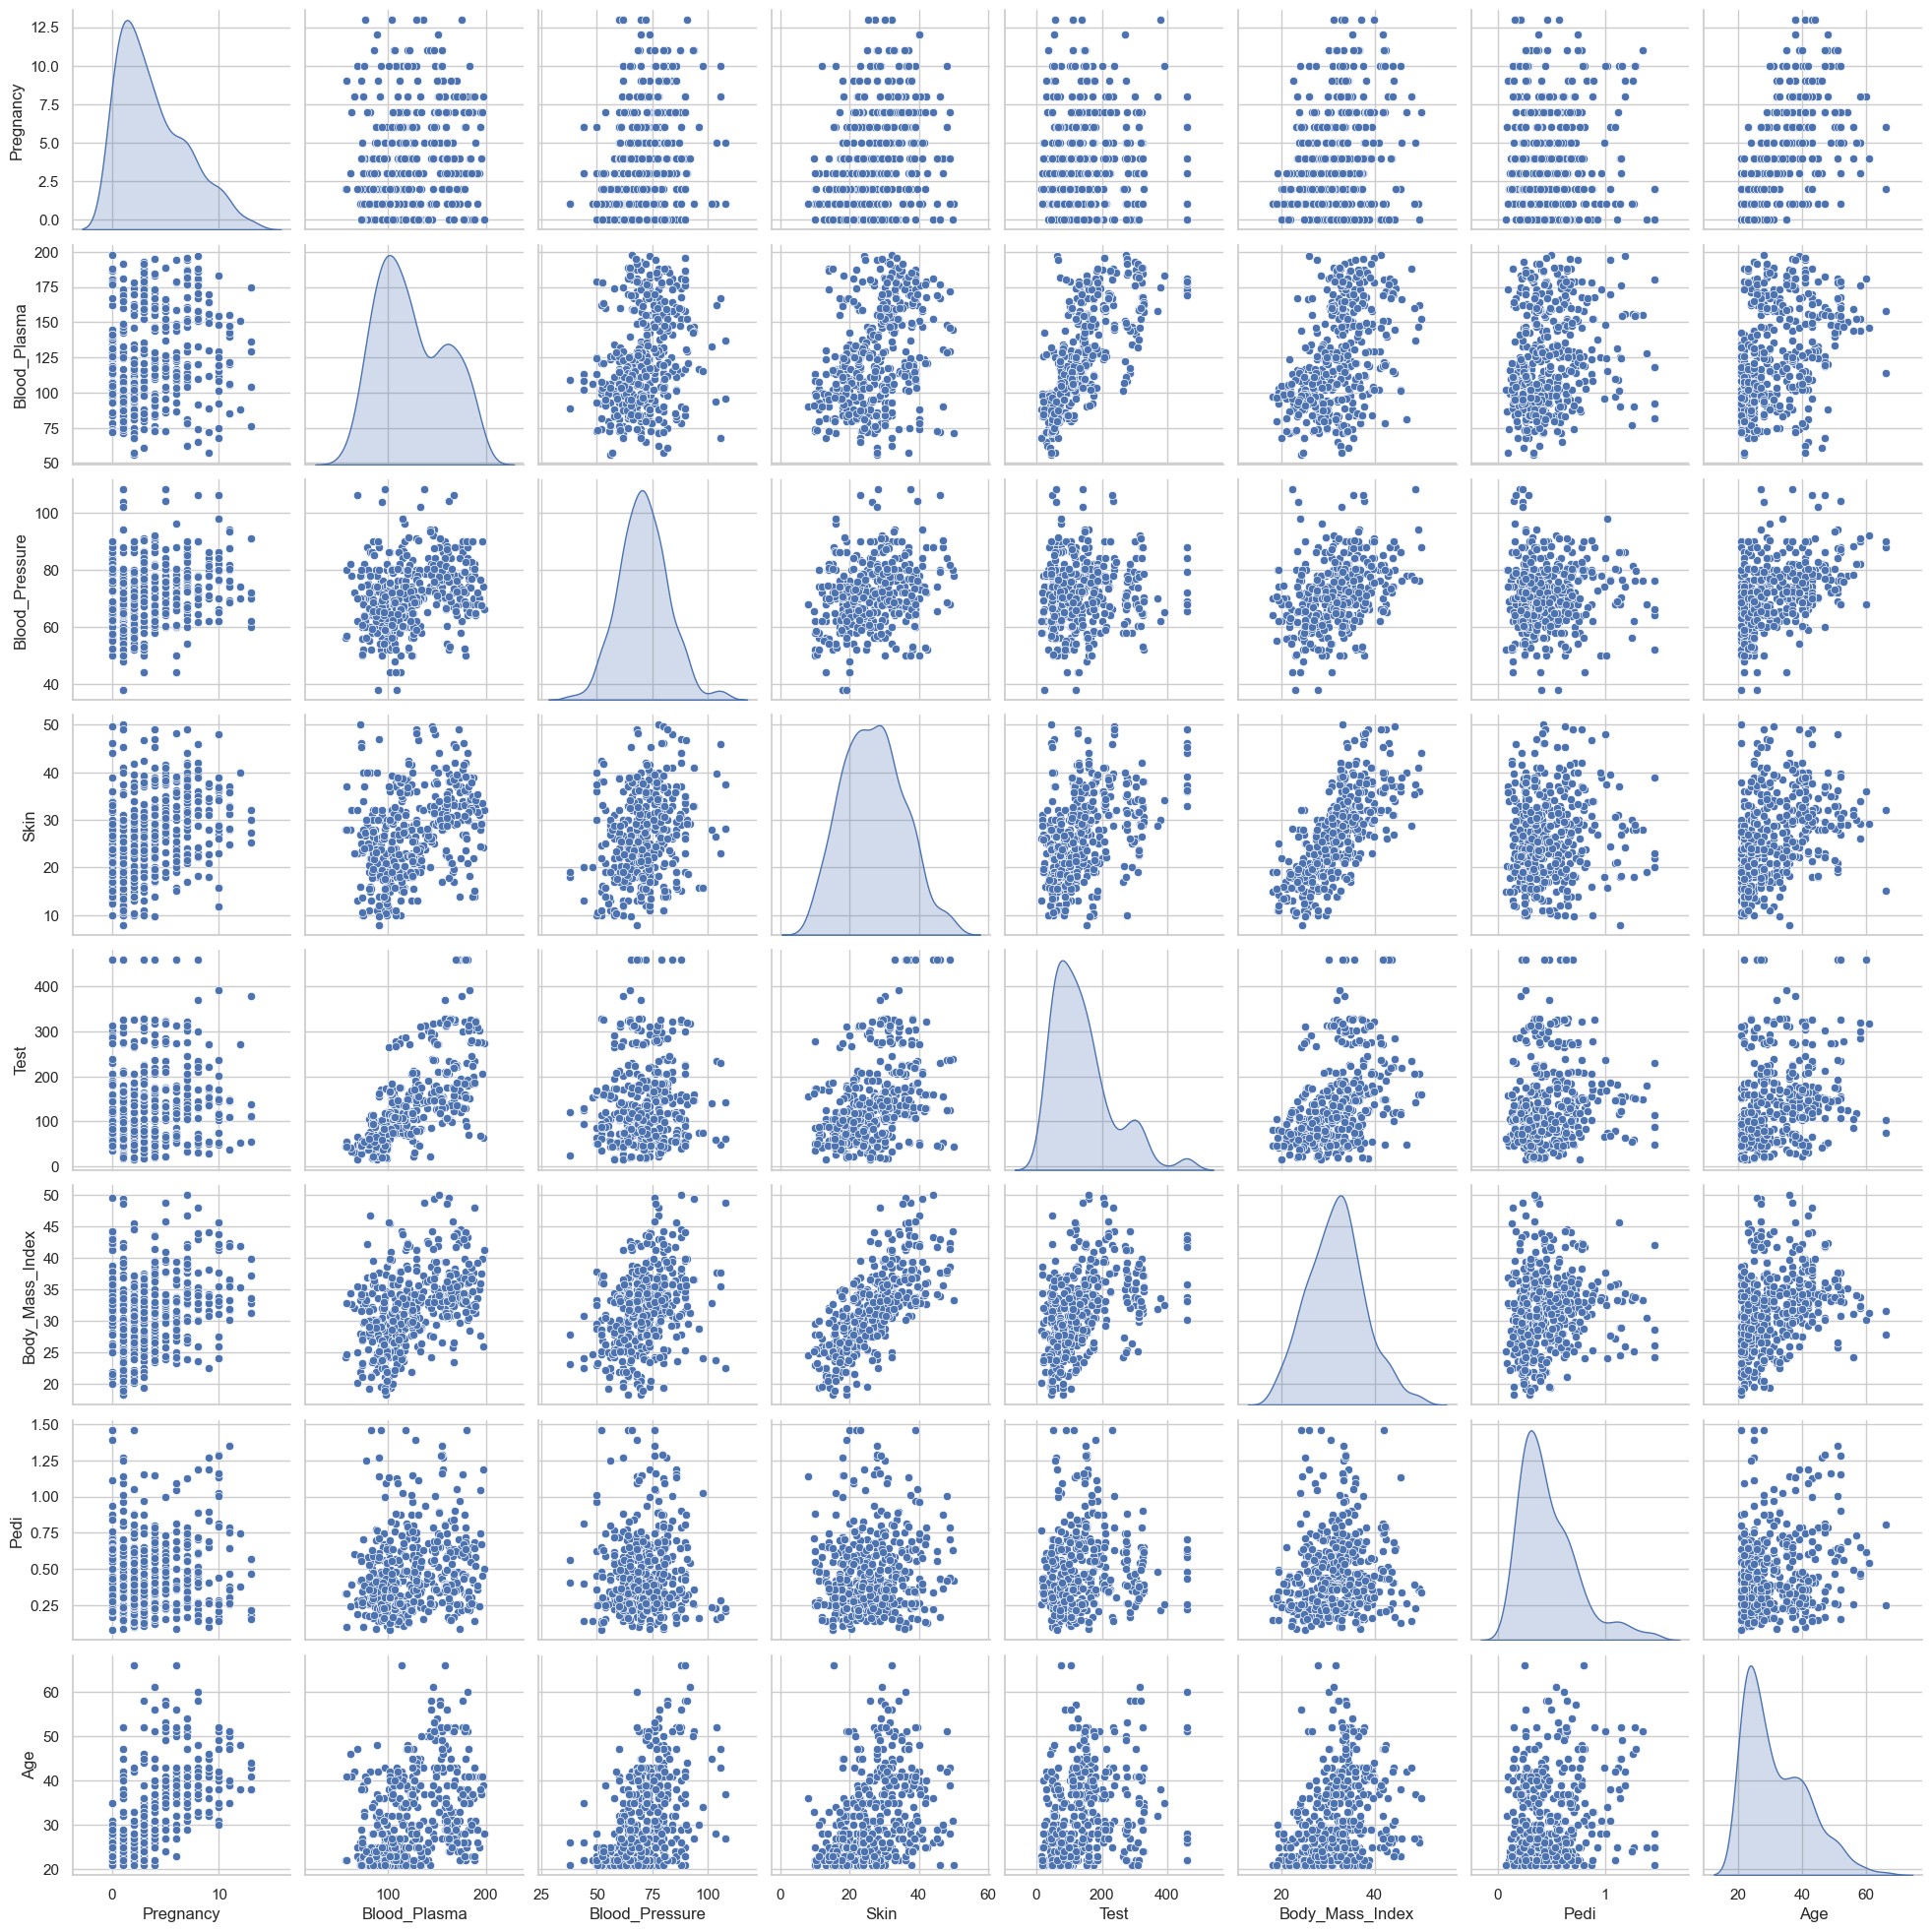

In [17]:
sns.pairplot( X_Train, diag_kind='kde' ); plt.show()

#####   
# Saving Balanced Data Sets

In [18]:
from openpyxl       import Workbook
from openpyxl.utils import get_column_letter
from openpyxl       import load_workbook

wb = Workbook()
dest_filename = 'Balanced_DataSets.xlsx'
Empty = wb.active; Empty.title='Empty'     

XX = X_Train.values.copy()    
xTrain = wb.create_sheet('xTrain')
xTrain.append( list(X_Train.columns) )
for i in range( XX.shape[0] ): xTrain.append( list( XX[i,:] )  )
                                                  
YY = y_Train.copy()    
yTrain = wb.create_sheet('yTrain')
yTrain.append( [estimated_column,estimated_column] )
for i in range( YY.shape[0] ): yTrain.append([  YY[i], YY[i]  ])

XX = X_Test.values.copy()    
xTest = wb.create_sheet('xTest')
xTest.append( list(X_Test.columns) )
for i in range( XX.shape[0] ): xTest.append( list( XX[i,:] )  )
                                                  
YY = y_Test.copy()    
yTest = wb.create_sheet('yTest')
yTest.append( [estimated_column,estimated_column] )
for i in range( YY.shape[0] ): yTest.append([  YY[i], YY[i]  ])

# Saving    
wb.save( filename = dest_filename )   

#####   
# Loading Balanced Data Sets

In [17]:
DataSet = 'Balanced_DataSets.xlsx'

X_Train =       pd.read_excel( DataSet, 'xTrain', header=0 )
y_Train = list( pd.read_excel( DataSet, 'yTrain', header=0 ).iloc[:,0] )

X_Test  =       pd.read_excel( DataSet, 'xTest',  header=0 )
y_Test  = list( pd.read_excel( DataSet, 'yTest',  header=0 ).iloc[:,0] )

#####   
# Making Gaussian Naive Bayes Estimators

In [27]:
# Metrics of Algorithms 
 
Metric_ALL = ['chebyshev', 'cityblock', 'euclidean', 'l1','l2', 'manhattan'] # 'minkowski'     
              
#sorted(sklearn.neighbors.VALID_METRICS['brute']) 
Metric_BRUTE = [ 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine' 
               , 'dice', 'euclidean', 'hamming', 'kulsinski', 'l1','l2', 'mahalanobis'
               , 'manhattan', 'matching', 'nan_euclidean', 'precomputed', 'rogerstanimoto'
               , 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean'
               , 'yule' ] # 'haversine', 'jaccard', 'minkowski' 

#sorted(sklearn.neighbors.VALID_METRICS['kd_tree']) 
Metric_KD_TREE = [ 'chebyshev', 'cityblock', 'euclidean', 'infinity', 'l1','l2', 'manhattan'
                 , 'p'  ] # 'minkowski'                                                                      

#sorted(sklearn.neighbors.VALID_METRICS['ball_tree']) 
Metric_BALL_TREE = [ 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'dice', 'euclidean'
                   , 'hamming', 'infinity', 'jaccard', 'kulsinski', 'l1','l2', 'mahalanobis'
                   , 'manhattan', 'matching', 'pyfunc', 'rogerstanimoto', 'russellrao'
                   , 'seuclidean' , 'sokalmichener' , 'sokalsneath', 'wminkowski'  
                   ]  # 'haversine', 'minkowski' 

#####   

In [41]:
# Importing Libraries
from sklearn.neighbors       import KNeighborsClassifier 
from sklearn.model_selection import StratifiedKFold
import time

# Scaling Datasets
x_train_scaled, y_train, x_test_scaled, y_test = scale(X_Train), y_Train, scale(X_Test), y_Test

# Needed Data
N_SPLITS     = 10
RANDOM_STATE =  3
SCORING      = 'accuracy'

# cross-validation strategy
CV = StratifiedKFold( n_splits=N_SPLITS, shuffle=True )

# (Manual)  
#Algorithm, Metric = 'auto'     , Metric_ALL             # nan      horrible
#Algorithm, Metric = 'brute'    , Metric_BRUTE           # error    horrible 
Algorithm, Metric = 'kd_tree'  , Metric_KD_TREE          # 73.5   goooooooood
#Algorithm, Metric = 'ball_tree', Metric_BALL_TREE       # error    horrible 

# (auto) Extra Data
N_SAMPLES = int(.5*x_train_scaled.shape[0]) 

# Hyper Parameters
CATs  = [ ['algorithm',     [ Algorithm ]       ] 
        , ['metric'   ,         Metric          ]  
        , ['weights'  , ['uniform', 'distance'] ]  
        ]
TFs   = [    
        ]
INTs  = [ ['n_neighbors',   3, min(25, N_SAMPLES), min(25-3+1, N_SAMPLES-3+1) ]
        , ['leaf_size'  ,   2,  16,  15  ]
        , ['p'          ,   1,  10,  10  ] 
        ]
CONTs = [ 
        ] 
            
# General Estimator 
ESTIMATOR  =  KNeighborsClassifier( metric_params =  None 
                                  , n_jobs        =  -1  
                                  )

## Hyper-Parameter Tuning by Genetic Algorithm

initiating ...


  0%|          | 0/3 [00:00<?, ?it/s]

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	200   	0.931223	0.0165271  	0.976179   	0.887095   
1  	388   	0.966645	0.00136158 	0.967391   	0.960962   
2  	374   	0.9761  	0.000482677	0.976226   	0.973959   


Best Parameters: {'algorithm': 'kd_tree', 'metric': 'l1', 'weights': 'distance', 'n_neighbors': 3, 'leaf_size': 4, 'p': 10}
accuracy = 0.9029126213592233


C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
C:\ProgramData\anaconda3\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)


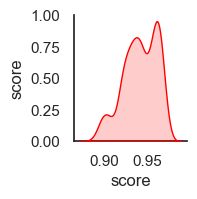


optimizing_time (min) = 4.0


In [48]:
# importing libraries

# pip install sklearn-genetic-opt
from sklearn_genetic           import GAFeatureSelectionCV, GASearchCV
from sklearn_genetic.callbacks import LogbookSaver, ProgressBar
from sklearn_genetic.space     import Categorical as GA_Categorical 
from sklearn_genetic.space     import Integer     as GA_Integer 
from sklearn_genetic.space     import Continuous  as GA_Continuous 
from sklearn_genetic.plots     import plot_fitness_evolution
from sklearn_genetic.plots     import plot_search_space

# defining G.A. Optimizer
def GA_Search( CATs,TFs,INTs,CONTs, ESTIMATOR,CV,Search_Space_Features,SCORING
             , Pop_Size,   Gens,   Tours,   Crossover,   Mutation
             , x_train_scaled, y_train, x_test_scaled, y_test ):
    
    callbacks = [LogbookSaver( checkpoint_path="./GA_logbook.pkl"),ProgressBar()]
    
    param_grid = {}
    for item in CATs:  param_grid[item[0]]=GA_Categorical(item[1])
    for item in TFs:   param_grid[item[0]]=GA_Categorical([True,False])
    for item in INTs:  param_grid[item[0]]=GA_Integer(item[1],item[2])
    for item in CONTs: param_grid[item[0]]=GA_Continuous(item[1],item[2],distribution=item[4])

    optimal_params = GASearchCV(
          estimator=ESTIMATOR, cv=CV, param_grid=param_grid, scoring=SCORING, population_size=Pop_Size
        , generations=Gens, tournament_size=Tours, elitism=True, keep_top_k=3, crossover_probability=Crossover
        , mutation_probability=Mutation, criteria="max", algorithm="eaMuCommaLambda", n_jobs=-1 ) 

    print('initiating ...')
    optimal_params.fit( x_train_scaled, y_train, callbacks = callbacks )

    accuracy = optimal_params.score( x_test_scaled, y_test )  
    print('\n\nBest Parameters:', optimal_params.best_params_)
    print('accuracy =', accuracy)
    
    plot_search_space( optimal_params, features=Search_Space_Features )
    plt.show()           
        
    Top_Params = optimal_params.logbook.chapters["parameters"]    
    return [ optimal_params.best_params_ , Top_Params ] 



# Initiating
t1 = time.time()

### Optimizing by G.A.
Pop_Size, Gens, Tours, Crossover, Mutation = 200,2,600, .50,.45 
Search_Space_Features   = [ 'score' ]
Best_Params, Top_Params = GA_Search(CATs,TFs,INTs,CONTs,ESTIMATOR,CV,Search_Space_Features,SCORING,
                                    Pop_Size,Gens,Tours,Crossover,Mutation, x_train_scaled, y_train, x_test_scaled, y_test )

t2 = time.time()
dt = np.round( (t2-t1)/60, 0 )
print( '\noptimizing_time (min) =', dt )

#####   
## Viewing Top 5 Hyper-Parameters

In [49]:
# Top 5 Hyper-Parameters
for i in range(10): print('\n\n\n', Top_Params[i] )




 {'index': 0, 'algorithm': 'kd_tree', 'metric': 'infinity', 'weights': 'distance', 'n_neighbors': 15, 'leaf_size': 2, 'p': 5, 'score': 0.9154486586493986, 'cv_scores': array([0.89361702, 0.91304348, 0.95652174, 0.93478261, 0.91304348,
       0.82608696, 0.91304348, 0.95652174, 0.91304348, 0.93478261]), 'fit_time': array([0.0029974 , 0.00299764, 0.0029974 , 0.00399685, 0.00299692,
       0.00300002, 0.00399733, 0.00399756, 0.00299859, 0.0029974 ]), 'score_time': array([0.01898813, 0.01798987, 0.0189898 , 0.02498507, 0.03498006,
       0.03097987, 0.02598143, 0.01598907, 0.0229857 , 0.01898909]), 'test_score': array([0.89361702, 0.91304348, 0.95652174, 0.93478261, 0.91304348,
       0.82608696, 0.91304348, 0.95652174, 0.91304348, 0.93478261]), 'train_score': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])}



 {'index': 1, 'algorithm': 'kd_tree', 'metric': 'cityblock', 'weights': 'uniform', 'n_neighbors': 12, 'leaf_size': 10, 'p': 5, 'score': 0.9347826086956521, 'cv_scores': array([1.

#####   
## Making Top 5 Estimators

In [60]:
# Making Top 5 Estimators
KNN_ = KNeighborsClassifier( algorithm='kd_tree', metric='l1', weights='distance', n_neighbors=3, leaf_size=4, p=10,
                             metric_params=None, n_jobs=-1 ).fit( x_train_scaled, y_train )

KNN0 = KNeighborsClassifier( algorithm='kd_tree', metric='infinity', weights='distance', n_neighbors=15, leaf_size=2, p=5,
                             metric_params=None, n_jobs=-1 ).fit( x_train_scaled, y_train )

KNN1 = KNeighborsClassifier( algorithm='kd_tree', metric='manhattan', weights='distance', n_neighbors=17, leaf_size=2, p=6,
                             metric_params=None, n_jobs=-1 ).fit( x_train_scaled, y_train )

KNN2 = KNeighborsClassifier( algorithm='kd_tree', metric='l1', weights='uniform', n_neighbors=19, leaf_size=3, p=2,
                             metric_params=None, n_jobs=-1 ).fit( x_train_scaled, y_train )

KNN3 = KNeighborsClassifier( algorithm='kd_tree', metric='l1', weights='distance', n_neighbors=7, leaf_size=6, p=10,
                             metric_params=None, n_jobs=-1 ).fit( x_train_scaled, y_train )

KNN4 = KNeighborsClassifier( algorithm='kd_tree', metric='l2', weights='distance', n_neighbors=25, leaf_size=9, p=10,
                             metric_params=None, n_jobs=-1 ).fit( x_train_scaled, y_train )

#####   
## Checking Accuracy, Recall & Precision of Top 5 Estimators

In [62]:
from sklearn.metrics import recall_score, precision_score, accuracy_score 

ESTIMATORS = [ KNN_, KNN0, KNN1, KNN2, KNN3, KNN4 ]
ACCURACIS, RECALLS, PRECISIONS = [],[],[]


for estimator in ESTIMATORS:
    y_pred  = estimator.predict( x_test_scaled )
    
    A_Score =  accuracy_score(y_test, y_pred,        normalize=True        )
    R_Score =    recall_score(y_test, y_pred, average=None, zero_division=1)  
    P_Score = precision_score(y_test, y_pred, average=None, zero_division=1)
    
    A_Score=np.round(A_Score*100,1);   ACCURACIS.append(A_Score)
    R_Score=np.round(R_Score*100,1);     RECALLS.append(R_Score)
    P_Score=np.round(P_Score*100,1);  PRECISIONS.append(P_Score)
    
Estimators_ARP = pd.DataFrame([ACCURACIS,RECALLS,PRECISIONS]).T
Estimators_ARP.columns = [ 'Accuracy','Recall','Precision' ]
Estimators_ARP.index   = [ 'KNN_', 'KNN0', 'KNN1', 'KNN2', 'KNN3', 'KNN4' ]

Estimators_ARP

,Accuracy,Recall,Precision
KNN_,90.3,"[84.9, 96.0]","[95.7, 85.7]"
KNN0,93.2,"[92.5, 94.0]","[94.2, 92.2]"
KNN1,96.1,"[94.3, 98.0]","[98.0, 94.2]"
KNN2,96.1,"[94.3, 98.0]","[98.0, 94.2]"
KNN3,97.1,"[94.3, 100.0]","[100.0, 94.3]"
KNN4,94.2,"[90.6, 98.0]","[98.0, 90.7]"


## Report: 
 - All Estimators Have Recall & Precision **> 80%** and can be used.

## Making Stacker & Voter

In [72]:
from sklearn.ensemble        import StackingClassifier, VotingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model    import LogisticRegression
from numpy import mean, std

level0 = list()
level0.append(('KNN_', KNN_ ))
level0.append(('KNN0', KNN0 )) 
level0.append(('KNN1', KNN1 )) 
level0.append(('KNN2', KNN2 )) 
level0.append(('KNN3', KNN3 )) 
level0.append(('KNN4', KNN4 ))  
# define meta learner model
level1  =  LogisticRegression()
# define the stacking ensemble
Stacker =  StackingClassifier( estimators=level0, final_estimator=level1, cv=10, passthrough=True,
                               stack_method='predict_proba' ).fit( x_train_scaled, y_train )
# define the votinging ensemble
Voter   =    VotingClassifier( estimators=level0, voting='soft' ).fit( x_train_scaled, y_train ) 

## Comparing The Estimators

       Mean    SD   
>KNN_ 0.957 (0.070)
>KNN0 0.909 (0.084)
>KNN1 0.924 (0.084)
>KNN2 0.826 (0.104)
>KNN3 0.961 (0.067)
>KNN4 0.894 (0.090)
>Stacker 0.990 (0.035)
>Voter   0.949 (0.075)


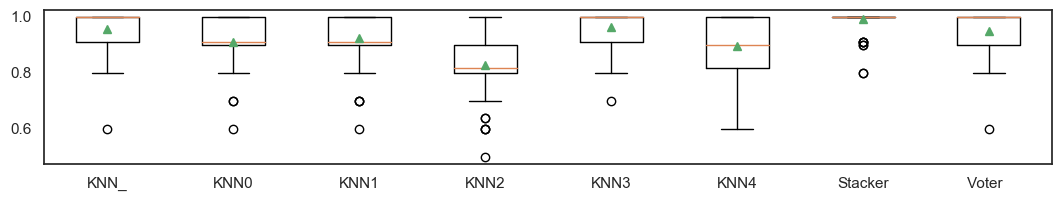

In [76]:
# Comparing The Estimators
models = dict()
models['KNN_'] = KNN_
models['KNN0'] = KNN0
models['KNN1'] = KNN1
models['KNN2'] = KNN2
models['KNN3'] = KNN3
models['KNN4'] = KNN4
models['Stacker'] = Stacker
models['Voter  '] = Voter

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=3)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

results, names = list(), list()
print('       Mean    SD   ') 
for name, model in models.items():
    scores = evaluate_model( model, x_test_scaled, y_test )
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    
# plot model performance for comparison
plt.boxplot( results, labels=names, showmeans=True );  plt.show()

## Report
 - As Stacker is Incredibly Good, It will be Visualized

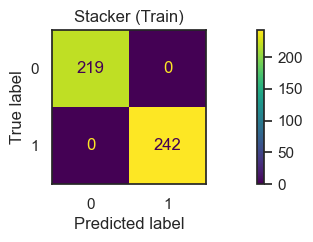

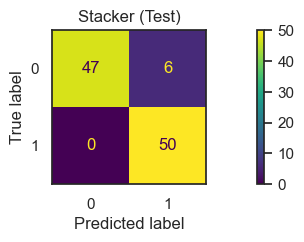

In [77]:
from sklearn.metrics import ConfusionMatrixDisplay
Classes = ['0','1']

# Training Performance
disp = ConfusionMatrixDisplay.from_estimator( Stacker, x_train_scaled, y_train, display_labels=Classes  )
plt.title( 'Stacker (Train)' ); plt.show()

# Test Performance
disp = ConfusionMatrixDisplay.from_estimator( Stacker, x_test_scaled, y_test, display_labels=Classes  )
plt.title( 'Stacker (Test)' ); plt.show()

## Report
 - Stacker is Pure Gold!!

#####   
# Making The Final Estimator

## Checkig Range of Features

In [66]:
X_Train.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancy,461.0,3.800434,3.172449,0.000,1.000,3.000000,6.000000,13.000000
Blood_Plasma,461.0,123.648691,34.754597,56.000,96.000,117.000000,154.246271,198.000000
Blood_Pressure,461.0,71.114090,11.116415,38.000,64.000,70.279119,78.000000,108.000000
Skin,461.0,26.784505,8.758054,8.000,20.000,26.611196,32.445212,50.000000
Test,461.0,139.948912,92.529148,15.000,71.000,118.733494,175.698663,459.164969
Body_Mass_Index,461.0,31.820215,6.075932,18.200,27.700,32.000000,35.500000,50.000000
Pedi,461.0,0.470463,0.270464,0.078,0.267,0.403000,0.614000,1.461000
Age,461.0,31.802603,9.673028,21.000,24.000,29.000000,38.000000,66.000000


## Choosing A Random Record To Be Predicted

In [67]:
# choosing a record in the test data set to be predicted
record_number = 75   

df = X_Test.copy()
print( np.round( df.loc[  record_number  ,:], 1 ) )

print( '\nExpected_Class = ', y_Test[  record_number  ] )

Pregnancy           13.0
Blood_Plasma       100.0
Blood_Pressure      78.0
Skin                25.0
Test               184.0
Body_Mass_Index     36.6
Pedi                 0.4
Age                 46.0
Name: 75, dtype: float64

Expected_Class =  1


## Entering The Record of Interest and Acceptable Range

In [68]:
# input data                Range

Pregnancy       =  13.0     #  0.0    13.0
Blood_Plasma    = 100.0     # 44.0   198.0
Blood_Pressure  =  78.0     # 38.0   108.0
Skin            =  25.0     #  8.0    54.0
Test            = 184.0     # 15.0   459.165
Body_Mass_Index =  36.6     # 18.2    53.2
Pedi            =   0.4     #  0.078   1.461
Age             =  46.0     # 21.0    68.0

#Class          =   1.0    

## Predicting 

In [69]:
# x 
x = X_Train.copy()

# s  written in the same order as  X_Train
s = [ Pregnancy, Blood_Plasma, Blood_Pressure, Skin, Test, Body_Mass_Index, Pedi, Age ]

encode_columns = [] 
def predicted_class( s, x, encode_columns ):
    s  = pd.DataFrame( [s.copy(),s.copy()], columns=x.columns )
    sx = pd.concat( [s,x], axis=0 )
    sx_encoded = pd.get_dummies(
          sx
        , columns = encode_columns
        )
    #print(sx_encoded.columns)
    sx_scaled = scale(  sx_encoded.iloc[1:,:]  )   
    sx_scaled = sx_scaled[[0,1]]  
    
    Estimator_Name, pred = [], [] 
    for key, value in models.items():
        clf = value
        Estimation = clf.predict( sx_scaled )[0]
        pred.append( Estimation ) 
        Estimator_Name.append( key )
        
    df_pred = pd.DataFrame( [pred] ).T
    df_pred.columns = ['Predicted Class']
    df_pred.index   = Estimator_Name
    
    return df_pred 

# Predicting
df_pred = predicted_class( s, x, encode_columns )
df_pred

,Predicted Class
KNN_,1
KNN0,1
KNN1,1
KNN2,1
KNN3,1
KNN4,1
Stacker,1
Voter,1


#####   

#####   